## Cleaning and preprocessing of raw data

In [6]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.preprocessing import MinMaxScaler
import string
from nltk.corpus import stopwords
from tensorflow.keras.regularizers import l2

# Download necessary NLTK resources
# nltk.download('punkt')
# nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
# Define directories for each dataset
directories = [
    'agoda_hotel_reviews',  
    'tripadvisor_hotel_reviews',
    'klook_hotel_reviews',  
    'booking_hotel_reviews'
]

In [7]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Function to load and normalize data
def load_and_normalize_data(directories):
    hotel_dfs = {}
    
    for directory in directories:           
        path = os.path.join('../raw data', directory)
        
        for filename in os.listdir(path):
            if filename.endswith('.csv'):
                # Extract hotel name from filename by removing undesired part
                hotel_name = os.path.splitext(filename)[0].replace('_reviews_2022_2024', '')
                
                df = pd.read_csv(os.path.join(path, filename))
                
                # Normalize the Review Score
                scaler = MinMaxScaler(feature_range=(0, 1))
                df['normalized_score'] = scaler.fit_transform(df[['Review Score']])

                # Add a new column for hotel name
                df['Hotel'] = hotel_name
                
                # Concatenate to the hotel DataFrame
                if hotel_name in hotel_dfs:
                    hotel_dfs[hotel_name] = pd.concat([hotel_dfs[hotel_name], df], ignore_index=True)
                else:
                    hotel_dfs[hotel_name] = df.reset_index(drop=True)

    return hotel_dfs


# Load and normalize data
hotel_dfs = load_and_normalize_data(directories)


In [8]:
print(list(hotel_dfs))

['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']


In [9]:
# Function to lemmatize text and check if it's in English
# for identifying english reviews
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
def preprocess_text(text):
    try:
        # Check if the review is in English
        lang = detect(text)
        if lang != 'en':
            return None  # Return None if not in English

        # Step 1: Convert text to lowercase
        text = text.lower()

        # Step 2: Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Step 3: Tokenization
        tokens = nltk.word_tokenize(text)

        # Step 4: Remove stop words
        tokens = [word for word in tokens if word not in stop_words]

        # Step 5: Lemmatization
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # Return the processed text as a single string
        return ' '.join(lemmatized_tokens)

    except LangDetectException as e:
        # If language detection fails, return None
        print(f"error: {e}")
        return None

# Loop through each hotel DataFrame and preprocess the review content
for hotel, df in hotel_dfs.items():
    # Apply preprocessing to the DataFrame's 'Review Content' column
    df['cleaned_content'] = df['Review Content'].apply(preprocess_text)

    # Identify and print the removed reviews (non-English)
    removed_reviews = df[df['cleaned_content'].isnull()]['Review Content']
    print(f"Removed reviews from {hotel}:")
    print(removed_reviews)

    # Drop rows where 'cleaned_content' is None (non-English reviews)
    df = df.dropna(subset=['cleaned_content'])

    # Update the DataFrame in the dictionary
    hotel_dfs[hotel] = df

# Display the cleaned DataFrames for each hotel
for hotel_name, df in hotel_dfs.items():
    print(f"\nCleaned DataFrame for {hotel_name}:")
    print(df)

error: No features in text.
Removed reviews from bai_hotel:
11                                    Excellent\r\n \r\n 
31      Napakaganda ang mura pa dito ulit ako mag ssta...
43                                        Good \r\n \r\n 
45                   No frills, reliable hotel.\r\n \r\n 
47                            Great experience \r\n \r\n 
                              ...                        
3872                                    \r\n All\r\n None
3897                              \r\n nice room\r\n none
3978    \r\n La gentillesse du personnel, la piscine, ...
4022                                       \r\n Good\r\n 
4032                           \r\n \r\n slow internet. 😔
Name: Review Content, Length: 173, dtype: object
error: No features in text.
error: No features in text.
Removed reviews from dusit_thani_mactan:
6                                     Excellent\r\n \r\n 
10                                        全てが最高\r\n \r\n 
19                              beautifu

In [10]:
# Train/Test Split and creation of labels
train_test_splits = {}
for hotel, df in hotel_dfs.items():
    df['label'] = df['normalized_score'].apply(lambda x: 0 if x <= 0.25 else (2 if x >= 0.75 else 1))

    # Perform 70-30 train-test split
    train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

    train_test_splits[hotel] = {
        'train': train_df,
        'test': test_df
    }

    print(f"\nTrain DataFrame for {hotel}:")
    print(train_df[['normalized_score', 'label']].describe())
    
    print(f"\nTest DataFrame for {hotel}:")
    print(test_df[['normalized_score', 'label']].describe())


Train DataFrame for bai_hotel:
       normalized_score        label
count       2706.000000  2706.000000
mean           0.909497     1.881005
std            0.177835     0.384392
min            0.000000     0.000000
25%            0.888889     2.000000
50%            1.000000     2.000000
75%            1.000000     2.000000
max            1.000000     2.000000

Test DataFrame for bai_hotel:
       normalized_score        label
count       1160.000000  1160.000000
mean           0.913204     1.882759
std            0.174687     0.378516
min            0.000000     0.000000
25%            0.900000     2.000000
50%            1.000000     2.000000
75%            1.000000     2.000000
max            1.000000     2.000000

Train DataFrame for dusit_thani_mactan:
       normalized_score        label
count       1283.000000  1283.000000
mean           0.813558     1.681995
std            0.263182     0.599177
min            0.000000     0.000000
25%            0.750000     2.000000
50%     

In [11]:
# Count the occurrences of each label
positive_count = 0
negative_count = 0
neutral_count = 0

for hotel, df in hotel_dfs.items():
    neutral_count += (df['label'] == 1).sum()
    negative_count += (df['label'] == 0).sum()
    positive_count += (df['label'] == 2).sum()

# Print the counts
print(f'Positive reviews: {positive_count}')
print(f'Negative reviews: {negative_count}')
print(f'Neutral reviews: {neutral_count}')
print(f"Total: {positive_count+negative_count+neutral_count}")

Positive reviews: 8008
Negative reviews: 383
Neutral reviews: 1406
Total: 9797


In [12]:
from sklearn.utils import shuffle
# Initialize combined lists
combined_X_train = []
combined_y_train = []

raw_train_data = {}
raw_test_data = {}

for hotel_name, df in hotel_dfs.items():
    # Split the dataset into training and testing sets
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        df['cleaned_content'], 
        df['label'], 
        test_size=0.3, 
        stratify=df['label'], 
        random_state=42
    )
    
    # Store raw train/test data
    raw_train_data[hotel_name] = (X_train_raw, y_train)
    raw_test_data[hotel_name] = (X_test_raw, y_test)

    # Add to combined lists
    combined_X_train.extend(X_train_raw)  # Use extend to flatten the list for strings
    combined_y_train.extend(y_train.tolist())  # Ensure y_train is a list to extend it
    
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(combined_X_train)  # Fit tokenizer on combined training data

# Convert texts to sequences
X_train_sequences = tokenizer.texts_to_sequences(combined_X_train)
X_test_sequences = []

# Optionally convert test texts into sequences for padding later
for hotel_name, (test_data, _) in raw_test_data.items():
    sequences = tokenizer.texts_to_sequences(test_data)
    X_test_sequences.append(sequences)

# Pad sequences to ensure uniform input size
X_train_padded = pad_sequences(X_train_sequences, maxlen=100)

# Pad test sequences for each hotel
X_test_padded = []
for sequences in X_test_sequences:
    padded_sequences = pad_sequences(sequences, maxlen=100)
    X_test_padded.append(padded_sequences)
    
# Shuffle the padded training data and corresponding labels
X_train_padded, combined_y_train = shuffle(X_train_padded, combined_y_train, random_state=42)

# Store the processed data in a combined format if desired
train_data = (X_train_padded, np.array(combined_y_train))  # Now a tuple of padded data and labels


# Prepare test data dictionary if needed
test_data = {}
for i, hotel_name in enumerate(raw_test_data.keys()):
    test_data[hotel_name] = X_test_padded[i], raw_test_data[hotel_name][1]  # Corresponding labels    


In [13]:
# Model creation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Model creation
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Adding L2 regularization
    Dropout(0.5),
    Dense(3, activation='softmax')  # Assuming 3 classes for multi-class classification
])

# Model Compilation
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

X_train_padded, y_train = train_data
# Model Training
history = model.fit(
    X_train_padded, 
    y_train, 
    epochs=10, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping]
)

Epoch 1/10


c:\Users\Predator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


172/172 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.8138 - loss: 0.8736 - val_accuracy: 0.8147 - val_loss: 0.6359
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.8224 - loss: 0.6469 - val_accuracy: 0.8147 - val_loss: 0.6181
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.8252 - loss: 0.6171 - val_accuracy: 0.8162 - val_loss: 0.5301
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.8461 - loss: 0.4769 - val_accuracy: 0.8315 - val_loss: 0.4625
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.8682 - loss: 0.4012 - val_accuracy: 0.8330 - val_loss: 0.4531
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.8985 - loss: 0.3456 - val_accuracy: 0.8439 - val_loss: 0.4658
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9017 - loss: 0.3312 - val_accuracy: 0.8344 - val_loss: 0.5044
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.9116 - loss: 0.3122 - val_accuracy: 0.8

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9131 - loss: 0.2784
Test Accuracy for bai_hotel: 0.9086
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7856 - loss: 0.5380
Test Accuracy for dusit_thani_mactan: 0.8004
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7500 - loss: 0.7936
Test Accuracy for fairfield_by_marriott_cebu: 0.7500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8131 - loss: 0.5120
Test Accuracy for jpark_island_resort_and_waterpark: 0.7975
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8214 - loss: 0.4943
Test Accuracy for seda_ayala_center_cebu: 0.8536
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7587 - loss: 0.6474
Test Accuracy for waterfront_hotel_and_casino: 0.7426


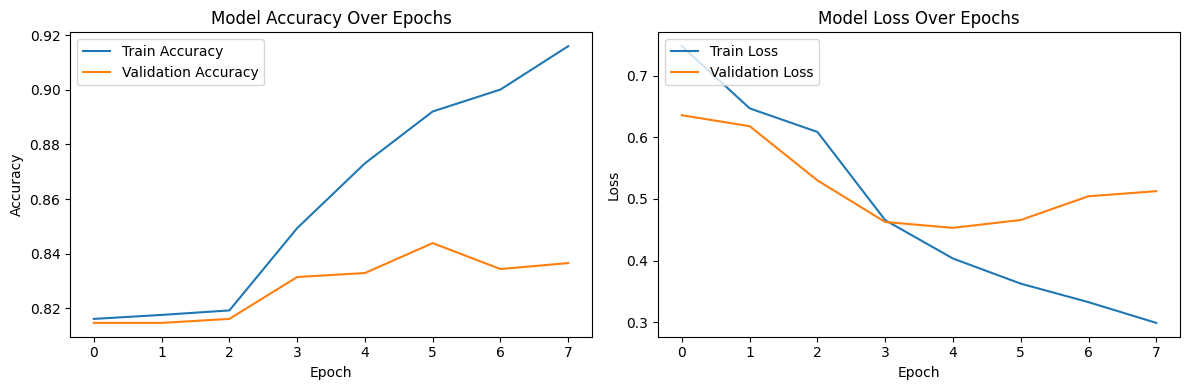

In [14]:

# Model Evaluation
# Note: Ensure to prepare X_test and y_test from your test data dictionary created earlier
for hotel_name, (X_test, y_test) in test_data.items():
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy for {hotel_name}: {accuracy:.4f}')

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [29]:
import os
import pandas as pd
import numpy as np

output_dir = 'predictions_by_hotel'
os.makedirs(output_dir, exist_ok=True)

for hotel_name, (X_test, y_test) in test_data.items():
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy for {hotel_name}: {accuracy:.4f}')
    
    # Make predictions
    predicted_scores = model.predict(X_test)  # Predicted scores give probabilities for each class
    
    
    
    # Convert predicted probabilities to class labels
    predicted_classes = np.argmax(predicted_scores, axis=1)  # Get index of max probability for each sample
    # Create a DataFrame to store true labels and predicted labels
    predictions = {
        'true_label': y_test,
        'predicted_class': predicted_classes,
        'predicted_scores': predicted_scores.tolist()  # Store the original probabilities if needed
    }
    
    # Convert to DataFrame
    predictions_df = pd.DataFrame(predictions)
    
    # Add hotel name to the DataFrame
    predictions_df['hotel_name'] = hotel_name
    
    # Save predictions to a CSV file, named after the hotel
    predictions_filename = os.path.join(output_dir, f'{hotel_name}_predictions.csv')
    predictions_df.to_csv(predictions_filename, index=False)

    print(f'Predictions for {hotel_name} saved to {predictions_filename}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9131 - loss: 0.2784
Test Accuracy for bai_hotel: 0.9086
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Predictions for bai_hotel saved to predictions_by_hotel\bai_hotel_predictions.csv
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7856 - loss: 0.5380
Test Accuracy for dusit_thani_mactan: 0.8004
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predictions for dusit_thani_mactan saved to predictions_by_hotel\dusit_thani_mactan_predictions.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7500 - loss: 0.7936
Test Accuracy for fairfield_by_marriott_cebu: 0.7500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predictions for fairfield_by_marriott_cebu saved to predictions_by_hotel\fairfield_by_marriott_cebu_predictions.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8131 - loss: 0.5120
Test Accuracy for jpark_island_resort_and_waterpark: 0.7975
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predictions for jpark_island_resort_and_waterpark saved to p

In [30]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example input reviews
new_reviews = [
    {"review": "The hotel staff was incredibly helpful and the room was clean and spacious. Definitely a positive experience!", "score": 1.0},
    {"review": "The location was good, but the room had a strange smell and the service was just okay.", "score": 0.6},
    {"review": "I had a terrible stay. The room was dirty and the staff was rude. Not worth the price.", "score": 0.2},
    {"review": "Amazing experience! The view from the room was breathtaking and the food at the restaurant was top-notch.", "score": 1.0},
    {"review": "The room was decent, but the Wi-Fi was slow and unreliable. It was an average stay overall.", "score": 0.5},
    {"review": "Terrible service! We waited over an hour for our room to be ready and the staff was not apologetic.", "score": 0.3},
    {"review": "The hotel was in a perfect location, close to all the major attractions. The room was comfortable and well-maintained.", "score": 0.9},
    {"review": "The facilities were outdated, and the air conditioning barely worked. I was disappointed with my stay.", "score": 0.4},
    {"review": "Great value for money! The hotel offered a lot of amenities and the staff was very friendly.", "score": 0.8},
    {"review": "The breakfast was good, but the room was small and the bed was uncomfortable. It was an okay stay.", "score": 0.6}
]

# Define a function to preprocess new input data
def preprocess_new_data(new_data):
    # Apply the same preprocessing function
    cleaned_data = [preprocess_text(entry["review"]) for entry in new_data]
    
    # Convert to sequences using the trained tokenizer
    sequences = tokenizer.texts_to_sequences(cleaned_data)
    
    # Pad the sequences
    padded_sequences = pad_sequences(sequences, maxlen=100)  # Use the same maxlen as your training data

    return padded_sequences

# Prepare reviews for prediction
padded_sequences = preprocess_new_data(new_reviews)

# Make predictions
predictions = model.predict(padded_sequences)

# Interpreting the predictions
for i, prediction in enumerate(predictions):
    predicted_label = np.argmax(prediction)  # Get the index of the highest probability
    predicted_score = prediction[predicted_label]  # The probability of the predicted class
    actual_score = new_reviews[i]["score"]

    # Assign sentiment based on the predicted label
    sentiment_labels = ['Negative', 'Neutral', 'Positive']
    sentiment = sentiment_labels[predicted_label]

    # Print the results
    print(f"Review: {new_reviews[i]['review']}")
    print(f"Actual Score: {actual_score:.2f}")
    print(f"Predicted Label: {sentiment}")
    print(f"Negative Probability: {prediction[0]:.2f}")
    print(f"Neutral Probability: {prediction[1]:.2f}")
    print(f"Positive Probability: {prediction[2]:.2f}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Review: The hotel staff was incredibly helpful and the room was clean and spacious. Definitely a positive experience!
Actual Score: 1.00
Predicted Label: Positive
Negative Probability: 0.00
Neutral Probability: 0.02
Positive Probability: 0.98
--------------------------------------------------
Review: The location was good, but the room had a strange smell and the service was just okay.
Actual Score: 0.60
Predicted Label: Neutral
Negative Probability: 0.11
Neutral Probability: 0.52
Positive Probability: 0.37
--------------------------------------------------
Review: I had a terrible stay. The room was dirty and the staff was rude. Not worth the price.
Actual Score: 0.20
Predicted Label: Neutral
Negative Probability: 0.16
Neutral Probability: 0.58
Positive Probability: 0.27
--------------------------------------------------
Review: Amazing experience! The view from the room was breathtaking and the food at the restaurant was top-notch.
Actual Score: 

In [ ]:
# from datetime import datetime
# import os

# # Assuming `model` is your Keras model
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# file_name = f'saved_models/general_sentiment_softmax_{timestamp}.keras'

# # Make sure the directory exists
# os.makedirs(os.path.dirname(file_name), exist_ok=True)

# # Save the model with the unique file name
# model.save(file_name)
# print(f"Model saved as {file_name}")
# model.summary()